# Further intro into PyTorch

Seminar outline:

- Data load
- Automatic differentiation
- From nn.Sequential to nn.Module
- TensorBoard

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline


## Data load

All dataset classes are subclasses of [`torch.util.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) have `__getitem__` and `__len__` methods implemented. Thus, it can be passed to a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), which can load multiple samples parallelly.
Popular Dataset subclasses:

- [MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
- [Fashion-MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist)
- [CIFAR](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)
- [CelebA](https://pytorch.org/docs/stable/torchvision/datasets.html#celeba)

`MNIST` constructor signature: `torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)`, where `transform` - function/transform that takes in an PIL (Height x Width x Channels) image and returns a transformed version. 

Several transformations can be combined together. Popular transformations:
- `torchvision.transforms.Normalize(mean, std, inplace=False)`
- `torchvision.transforms.ToTensor()` - Converts a PIL Image or `numpy.ndarray` (H x W x C) in the range `[0, 255]` to a `torch.FloatTensor` of shape (C x H x W) in the range `[0.0, 1.0]` 


DataLoader constructor signature
`torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None)`, where
- dataset is DataSet instance
- batch_size - number of items sampled at every iteration
- num_workers - number of simultaneous reading processes (**NB** on Windows you might want to set it to `0`)

DataLoaders provide convenient interface for training loops: 

```python
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            ...
            
```
or 
```python
    batch_X, batch_y = iter(trainloader).next()
```

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

ds_train = datasets.MNIST(".", train=True, download=True, transform=transform)
ds_test = datasets.MNIST(".", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(ds_train, batch_size=512,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(ds_test, batch_size=10000,
                                        shuffle=False, num_workers=2)

In [ ]:
print("Train:", ds_train, "\nTest:", ds_test)

In [ ]:
X_batch, y_batch = iter(trainloader).next()
print("batch size:", len(X_batch), "batch dimensions:", X_batch.shape)

In [ ]:
plt.figure(figsize=(4, 4), dpi=100)
plt.axis('off')

plt.imshow(
    torch.transpose(
        torch.cat(
            [X_batch[y_batch == c][:10] for c in range(10)], axis=0
        ).reshape(10, 10, 28, 28),
        1, 2
    ).reshape(280, 280)
)
plt.show()

## Automatic differentiation
Automatic differentiaion is the main mechanism for the backpropagation in PyTorch. PyTorch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` context:

```
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```
Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [ ]:
x = torch.randn(2,2, requires_grad=True)
print(x)

In [ ]:
y = x**2
print(y)

Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [ ]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [ ]:
z = y.mean()
print(z)

You can check the gradients for `x` and `y` but they are empty currently.

In [ ]:
print(x.grad)

To calculate the gradients, you need to run the `.backward` method on a variable `z`, for example. This will calculate the gradient for `z` with respect to `x`

$$\frac{\partial z}{\partial x}=\frac{\partial}{\partial x}\left[\frac{1}{n} \sum_{i}^{n} x_{i}^{2}\right]=\frac{x}{2}$$

In [ ]:
z.backward()
print(x.grad)
print(x/2)

These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step.

## Loss and Autograd together
When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [ ]:
if torch.cuda.is_available():         
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# create a network that stacks layers on top of each other
model = nn.Sequential(
    nn.Linear(784, 100), # add first "dense" layer with 784 input
                         # units and 100 output units (hidden layer
                         # with 100 neurons).
    nn.ReLU(),
    nn.Linear(100, 10), # "dense" layer with 10 output
                        # units (for 10 classes).
).to(device)

print("Weight shapes:")
for w in model.parameters():
    print("  ", w.shape)

If we give our batch to the model, we get an exception of dimension mismatch, since batch dimensions are 512 x 28 x 28 x 1, while model expects 512 x 784, so we need to flatten the trailing dimensions. You can use method `torch.flatten(input, start_dim=0, end_dim=-1) → Tensor`

    >>> t = torch.tensor([[[1, 2],
                       [3, 4]],
                      [[5, 6],
                       [7, 8]]])
    >>> torch.flatten(t)
    tensor([1, 2, 3, 4, 5, 6, 7, 8])
    >>> torch.flatten(t, start_dim=1)
    tensor([[1, 2, 3, 4],
            [5, 6, 7, 8]])



In [ ]:
def flatten_trailing(batch):
    # your code here
    raise NotImplementedError
    return flat

In [ ]:
assert flatten_trailing(X_batch).shape == (512, 784)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

predictions = model(flatten_trailing(X_batch.to(device)))

In [ ]:
loss = loss_fn(predictions, y_batch.to(device))

In [ ]:
print('Before backward pass: \n', model[2].weight.grad)

loss.backward()

print('After backward pass: \n', model[2].weight.grad[0])

If we try to call backward once again, the graph buffers are deallocated and we are going to get 
> RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.


In [ ]:
try:
    loss.backward()
except Exception as e:
    print("Got Exception", type(e), e)
else:
    print("No exception")

## From nn.Sequential to nn.Module

In [ ]:
def train(model, num_epochs=1, batch_size=512, loss_fn=loss_fn, device='cpu'):
    # some quantities to plot
    train_losses = []
    test_losses = []
    test_accuracy = []
    model_dev = model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    for i_epoch in range(num_epochs):
        t = tqdm.tqdm(iter(trainloader), leave=False, total=len(trainloader))
        for idx, data in enumerate(t):
            # get the next chunk (batch) of data:
            batch_X, batch_y = map(lambda x: x.to(device), data)

            # all the black magic:
            loss = loss_fn(model(flatten_trailing(batch_X)), batch_y)
            loss.backward()
            opt.step()
            opt.zero_grad()

            # remember the loss value at this step
            train_losses.append(loss.item())

        # evaluate test loss and metrics
        test_X, test_y = map(lambda x: x.to(device), iter(testloader).next())

        test_prediction = model(flatten_trailing(test_X.to(device)))
        test_losses.append(
            loss_fn(test_prediction, test_y).item()
        )
        test_accuracy.append(
            (test_prediction.argmax(axis=1) == test_y).to(float).mean()
        )

        # all the rest is simply plotting

        clear_output(wait=True)
        plt.figure(figsize=(8, 3), dpi=100)
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='train')
        plt.plot(
            np.linspace(0, len(train_losses), len(test_losses) + 1)[1:],
            test_losses, label='test'
        )
        plt.ylabel("Loss")
        plt.xlabel("# steps")
        plt.legend();

        plt.subplot(1, 2, 2)
        plt.plot(test_accuracy, "o-")
        plt.ylabel("Test accuracy")
        plt.xlabel("# epochs");
        plt.show()
    return train_losses, test_losses, test_accuracy

In [ ]:
train(model, num_epochs=2, device=device);

In [ ]:
class Net(nn.Module):
    def __init__(self, n=100):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, n)
        self.fc2 = nn.Linear(n, 10)
        
    def forward(self, X):
        Xf = X.flatten(1) # we add `flatten` here
        X1 = F.relu(self.fc1(Xf))
        return self.fc2(X1)

In [ ]:
model2 = Net().to(device)

In [ ]:
train(model2, device=device);

## Tensorboard

Now we’ll set up TensorBoard, importing `tensorboard` from `torch.utils` and creating a `SummaryWriter` - the key object for writing information to TensorBoard. Useful methods of [`SummaryWriter`](https://pytorch.org/docs/stable/tensorboard.html?highlight=summarywriter#torch.utils.tensorboard.writer.SummaryWriter):
- add_scalar - for storing points that can be visualized as plots
- add_histogram - for storing histograms
- add_image - for storing images 
- add_figure - for storing matplotlib figures

In [ ]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/MNIST_Y')

Note that this line creates a `runs/MNIST_X` folder.

In [ ]:
train_X, train_y = map(lambda x: x.to(device), iter(trainloader).next())


In [ ]:
img = torch.transpose(
        torch.cat(
            [train_X[train_y == c][:10] for c in range(10)], axis=0
        ).reshape(10, 10, 28, 28),
        1, 2
    ).reshape(280, 280).cpu()

In [ ]:
plt.imshow(img)
plt.show()
print(img.shape)

In [ ]:
# the last argument of add_image is image in CxHxW format
writer.add_image('MNIST', img.view(1, 280, 280))

Now you have to run tensorboard in a separate terminal window using the script: 

`~/mlhep2020/scripts/tboard-cocalc`

and open the tensorboard by the 1st URL the script suggests in a separate browser window.

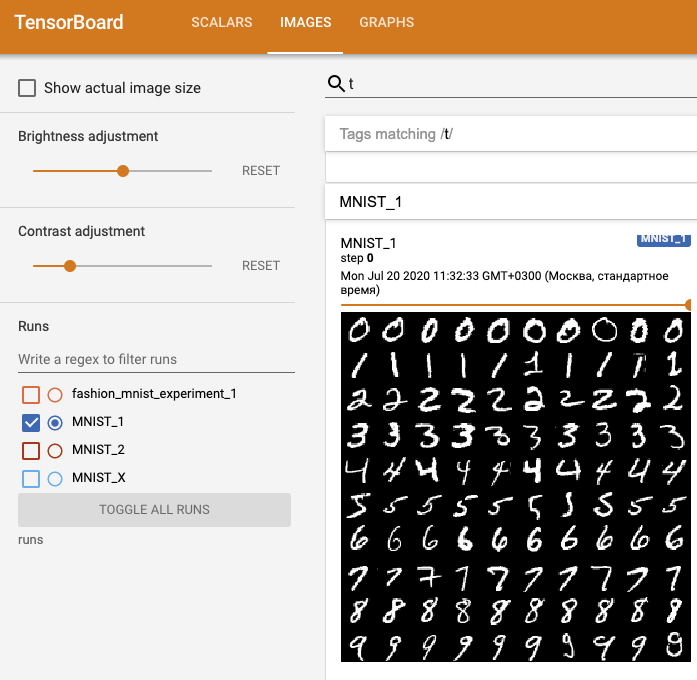

`.add_graph` stores graph of the model in the interactive form

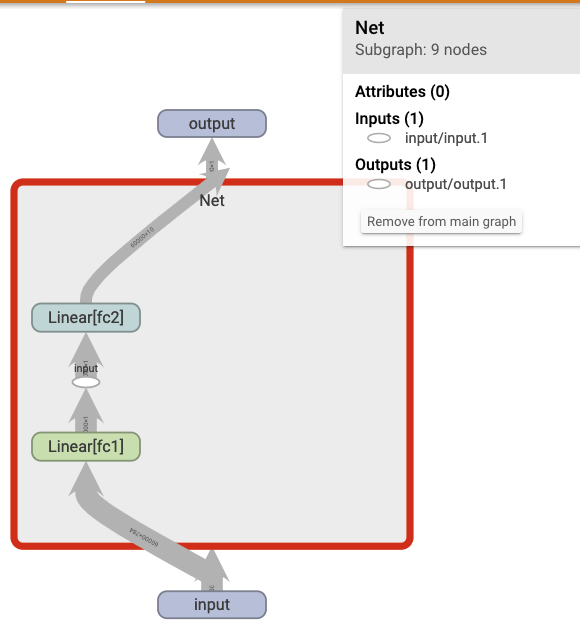

In [ ]:
writer.add_graph(model2, train_X)

In [ ]:
# helper functions
def matplotlib_imshow(img, one_channel=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, classes):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 3))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [ ]:
def train_tb(model, num_epoch=1, batch_size=512, device='cpu', tag='training loss'):
    running_loss = 0.0
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(num_epoch):  # loop over the dataset multiple times

        t = tqdm.tqdm(iter(trainloader), leave=False, total=len(trainloader))
        for idx, data in enumerate(t):
            # get the next chunk (batch) of data:
            batch_X, batch_y = map(lambda x: x.to(device), data)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()

            writer.add_scalar(tag,
                            loss.item(),
                            epoch * len(batch_y) + idx)
            if idx % 20 == 0:
                writer.add_figure(f'{tag}/predictions_vs_actuals',
                            plot_classes_preds(model,
                                               batch_X[:4],
                                               batch_y[:4],
                                               trainloader.dataset.classes),
                            global_step=epoch * len(trainloader) + idx)

    print('Finished Training')

In [ ]:
model3 = Net().to(device)

In [ ]:
train_tb(model3, device=device, tag='MyTraining-2')

Every 20 iterations of the training loop we have saved images with predictions:

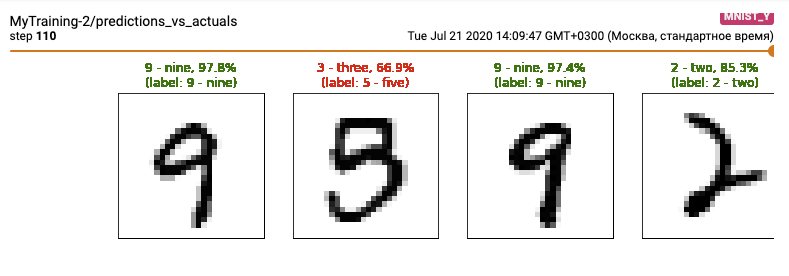

In case your notebook is running **locally** you can upload your tensorboard state to public service [https://tensorboard.dev/](https://tensorboard.dev/) by running command 

```bash
tensorboard dev upload --logdir runs \
  --name "My latest experiment" \ # optional
  --description "Simple comparison of several hyperparameters" # optional
```

**Note:** Uploaded TensorBoards are public and visible to everyone. Do not upload sensitive data.

For help, run `$ tensorboard dev upload --help.`

### More information on tensorboard:

- https://pytorch.org/docs/stable/tensorboard.html
- https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
- https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html